In [2]:
# import libraries 
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
plt.rcParams.update({'font.size': 16})  # Adjust the font size as needed
MCMC_SAMPLE = 36

CEILING = 9000
FLOOR = 500

series = [7075,5558,5841,4883,628,6506,4357,6855,6397,5663,5924,
          1580,318,2745,4104,5325,4173,6102,6581,5877,4559,3832,
          4445,4218,4251,3687,3880,4229,3737,3213,3335,2950,1335,
          1675,2641,2267]

timeline = ['2015-01', '', '', '2015-04', '', '', '2015-07', '', '', '2015-10', '', '',
            '2016-01', '', '', '2016-04', '', '', '2016-07', '', '', '2016-10', '', '',
            '2017-01', '', '', '2017-04', '', '', '2017-07', '', '', '2017-10', '', '']

train_ratio = 0.66
train_size = int(len(series) * train_ratio)
series_train = np.array(series[:train_size])
series_test = np.array(series[train_size:])

23:52:33 - cmdstanpy - INFO - Chain [1] start processing
23:52:33 - cmdstanpy - INFO - Chain [1] done processing


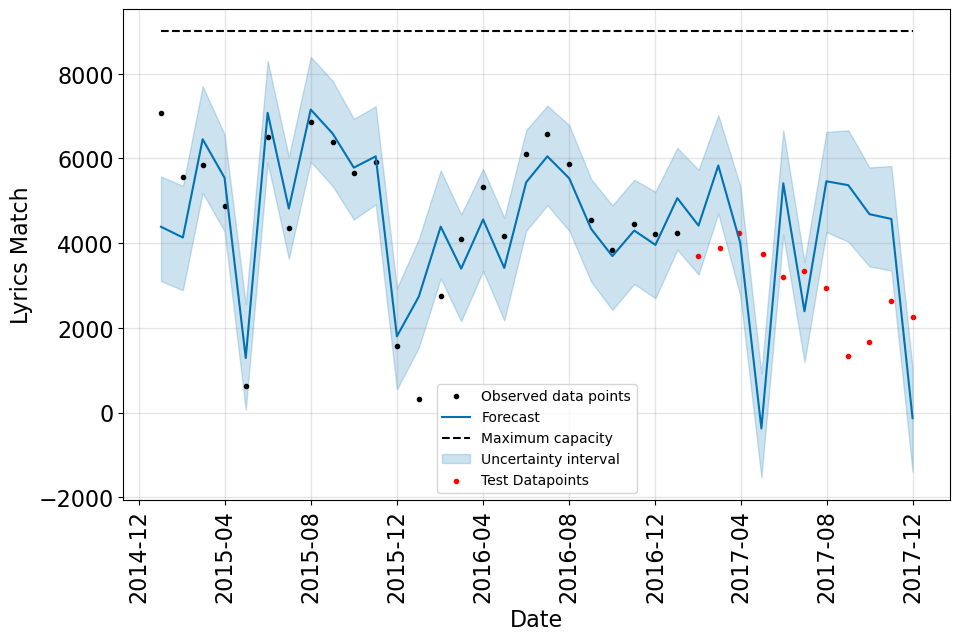

In [4]:
# Read and prepare the data
data = pd.read_csv('Lyrics-Match-3-years-book-keeping - All-monthly.csv')
prophet_df = pd.DataFrame(data, columns=['Unnamed: 0', 'Lyrics Match'])
prophet_df = prophet_df.rename(columns={'Unnamed: 0':'ds', 'Lyrics Match':'y'})
prophet_df['floor'] = FLOOR
prophet_df['cap'] = CEILING

testing_x = [17196,17227, 17255,17288, 17316,17347, 17377,17408, 17439,17469, 17500]
testing_y = [3687,3880,4229,3737,3213,3335,2950,1335,1675,2641,2267]

# Split the data into training and testing datasets
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Initialize and train the Prophet model on the training dataset
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_df)

# Make future dataframe for the testing period
future = m.make_future_dataframe(periods=len(test_df), freq='M')
future['floor'] = FLOOR
future['cap'] = CEILING

# Make predictions
forecast = m.predict(future)
figure = m.plot(forecast, xlabel='Date', ylabel='Lyrics Match')
prophet_df

# Get the current axis
ax = figure.gca()

# Add the test dataset to the same plot
ax.scatter(testing_x, testing_y, label='Test Datapoints', marker='.', color='red')

# # Add legend
ax.legend(fontsize=10)


plt.xticks(rotation=90)  # Rotate x-tick labels by 45 degrees
plt.show()

In [5]:
# Extract the predictions for the test period
forecast_test = forecast[['ds', 'yhat']].tail(len(test_df))

# Merge actual and predicted values
merged_df = pd.concat([test_df, forecast_test[['yhat']]], axis = 1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))
print('RMSE:', rmse)

# Get the initial slope (k) and intercept (m)
k = (forecast['trend'][35] - forecast['trend'][0])/35
m = forecast['trend'][0]

# Print the slope and intercept
print(f"Slope (m): {k}")
print(f"Intercept (b): {m}")

RMSE: 2489.2801403292833
Slope (m): -65.12451743718513
Intercept (b): 5808.2071


In [6]:
predicted = list(forecast['trend'][-12:])
actual = [4251,3687,3880,4229,3737,3213,3335,2950,1335,1675,2641,2267]
actual = np.array(actual)
predicted = np.array(predicted)
rmse = np.sqrt(np.mean((actual - predicted) ** 2))

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1080.6812038040766


In [8]:
def r2_score(actual, predicted):
    mean_of_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_of_actual) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [9]:
print('r2 score', r2_score(actual, predicted))

r2 score -0.3876950121530842
